## <center><font color='#5632a8'> Clustering Explainability </center>

https://www.askpython.com/python/examples/plot-k-means-clusters-python

In [1]:
import pandas as pd 
import numpy as np   
import seaborn as sns 
from datetime import datetime
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def remove_outliers(df): 
    df = df[df.Monetary < 3000000][:]   ## removing Magnates 
    don_juans = df[(df.Monetary > 200000) & (df.Frequency <=2)]
    df = df.drop(don_juans.index)       ## removing Don Juans 
    return df 

### <font color='#5632a8'> Loading data 

In [3]:
dataset = pd.read_csv("generated_dataset/mytaxi_rfm_extended_dataset.csv") 
# dataset = remove_outliers(dataset) 

frameRFM = dataset[['Recency', 'Frequency', 'Monetary']]
frameRFAC = dataset[['Recency_RFAC', 'Frequency', 'Average_RFAC', 'favorite_RFAC']] 
frameExtended = dataset.drop(['ClientID'], axis=1) 

In [23]:
from sklearn.preprocessing import StandardScaler 

SCALER = StandardScaler()  # MinMaxScaler()

def scale_dataset(data): 
    SCALER.fit(data) 
    
    scaled_data = SCALER.transform(data)    
    
    return scaled_data

### <font color='#5632a8'> ExKMC </font> 

> * https://github.com/navefr/ExKMC 
> * https://arxiv.org/pdf/2006.02399.pdf 

In [6]:
from ExKMC.Tree import Tree 
from sklearn.cluster import KMeans
from xai_utils import calc_cost, plot_kmeans, plot_tree_boundary

In [27]:
k = 7
X = frameRFM.copy()

# Initialize tree with up to 6 leaves, predicting 3 clusters
tree = Tree(k=k, max_leaves=40) 

# Construct the tree, and return cluster labels
prediction = tree.fit_predict(X)

# Tree plot saved to filename
tree.plot('filename')

In [28]:
scaled_X = scale_dataset(X)

# Initialize tree with up to 6 leaves, predicting 3 clusters
tree = Tree(k=k, max_leaves=40) 

# Construct the tree, and return cluster labels
prediction = tree.fit_predict(scaled_X)

# Tree plot saved to filename
tree.plot('filename1')

### <font color='#5632a8'> Feature Importance on Clustering </font> 
> * https://github.com/YousefGh/kmeans-feature-importance 
> * https://towardsdatascience.com/interpretable-k-means-clusters-feature-importances-7e516eeb8d3c

In [11]:
from kmeans_interp import KMeansInterp

In [12]:
k = 7
X = frameRFM.copy()

kms = KMeansInterp(
    n_clusters=k,
    ordered_feature_names=X.columns.tolist(), 
    feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(X.values)

In [14]:
kms.feature_importances_[0][:10] # Important feaures for cluster 1 

[('Monetary', 1343883.233618232),
 ('Recency', 68.65313390313423),
 ('Frequency', 61.853276353276314)]

In [15]:
kms.feature_importances_[1][:10] # Important feaures for cluster 2

[('Monetary', 59194.68570126439),
 ('Recency', 551.4438074265322),
 ('Frequency', 2.8391297744707416)]

In [16]:
kms.feature_importances_[2][:10] # Important feaures for cluster 3 

[('Monetary', 321346.44173441693),
 ('Recency', 181.47871831659532),
 ('Frequency', 14.863542164833387)]

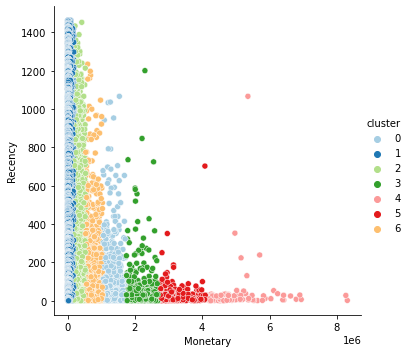

In [17]:
X['cluster'] = kms.predict(X.values) 

sns.relplot(x='Monetary', y='Recency', hue='cluster', data=X, palette = "Paired")

#### With Normalization! 

In [19]:
k = 7
X = frameRFM.copy()
scaled_X = scale_dataset(X)

kms = KMeansInterp(
    n_clusters=k,
    ordered_feature_names=X.columns.tolist(), 
    feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(scaled_X)


kms.feature_importances_[0][:10] # Important feaures for cluster 1 

[('Recency', 0.6250442515878876),
 ('Frequency', 0.3287071178725069),
 ('Monetary', 0.3222710269107823)]

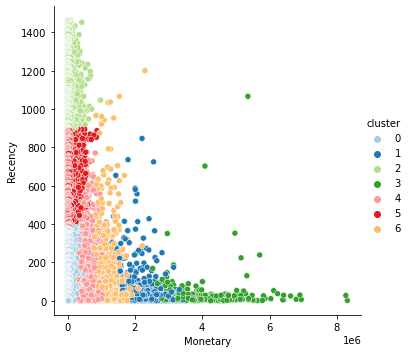

In [22]:
X['cluster'] = kms.predict(scaled_X) 

sns.relplot(x='Monetary', y='Recency', hue='cluster', data=X, palette = "Paired")

In [26]:
X

,Recency,Frequency,Monetary,cluster
0,4,46,1345331.0,6
1,560,14,204514.0,5
2,1272,1,18300.0,2
3,1104,2,41400.0,2
4,84,94,2180218.0,1
...,...,...,...,...
37985,2,1,28800.0,0
37986,2,1,33900.0,0
37987,2,1,43800.0,0
37988,2,1,29800.0,0


### <font color='purple'> Dendrogram </font> 